In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
import shap
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold,cross_validate
from sklearn.base import clone



from implicit import als
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from implicit.bpr import BayesianPersonalizedRanking
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import shap
# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from recommenders import MainRecommender

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

In [10]:
# Изменим гиперпараметры

recommender.model=recommender.fit(recommender.user_item_matrix,random=50, n_factors=4, regularization=0.03, iterations=10, num_threads=4)

In [7]:
def metr(X_train,y_train,train_preds):
    X_res=X_train[['user_id','item_id']]
    X_res['pred']=train_preds[:,1]
    X_res['tag']=y_train
    X_res=X_res.groupby(['user_id','item_id']).mean().reset_index()
    metric=[]
    for user in X_res.user_id.unique():
        m=X_res[X_res.user_id==user].sort_values('pred',ascending = False)[:5].tag.sum()/5
        metric.append(m)
    return np.mean(metric)

In [8]:
def prep_data(data_train_lvl_2,n1=10,n2=10,n3=5,n4=12):
    users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
    reduce_mem_usage(users_lvl_2)
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    train_users = list(set(data_train_lvl_1['user_id'].unique()) & set(data_val_lvl_1['user_id'].unique()) & set(data_val_lvl_2['user_id'].unique()))
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    
    users_lvl_2['candidates1'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=n1))
    users_lvl_2['candidates2'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n2))
#     users_lvl_2['candidates3'] = users_lvl_2['user_id'].apply(lambda x: recommender.overall_top_purchases[:n3])
    users_lvl_2['candidates4'] = users_lvl_2['user_id'].apply(lambda x: recommender.top_purchases[recommender.top_purchases.user_id==x].item_id[:n4].to_list())
    users_lvl_2['candidates'] = users_lvl_2.candidates1+users_lvl_2.candidates2+users_lvl_2.candidates4
    users_lvl_2=users_lvl_2.drop(['candidates1','candidates2','candidates4'],axis=1)
    
    
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    
    s.name = 'item_id'
   
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1
    users_lvl_2=users_lvl_2.groupby(['user_id','item_id']).mean().reset_index()

    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 
    
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
   
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)
    
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
    
    targets_lvl_2.age_desc.replace(['45-54','35-44','25-34','65+','55-64','19-24'],[50,40,30,70,60,20],inplace=True)
    targets_lvl_2.age_desc.fillna((targets_lvl_2.age_desc.mean()),inplace=True)
    
    targets_lvl_2.marital_status_code.replace(['U','A','B'],[2,1,0],inplace=True)
    targets_lvl_2.marital_status_code.fillna(10,inplace=True)
    

#     targets_lvl_2.income_desc.replace(['50-74K','35-49K','75-99K'],[75,50,100],inplace=True)
#     targets_lvl_2.income_desc.replace(['25-34K','15-24K','Under 15K'],[35,25,15],inplace=True)
#     targets_lvl_2.income_desc.replace(['125-149K','100-124K','150-174K'],[150,125,175],inplace=True)
#     targets_lvl_2.income_desc.replace(['175-199K','250K+','200-249K'],[200,300,250],inplace=True)
#     targets_lvl_2.income_desc.fillna(targets_lvl_2.income_desc.median(),inplace=True)
    
#     targets_lvl_2.household_size_desc.value_counts()
#     targets_lvl_2.household_size_desc.replace(['2','1','3','5+','4'],[2,1,3,5,4],inplace=True)
#     targets_lvl_2.household_size_desc.fillna(targets_lvl_2.household_size_desc.mean(),inplace=True)
    
#     targets_lvl_2.kid_category_desc.replace(['None/Unknown','1','3+','2'],[0,1,3,2],inplace=True)
#     targets_lvl_2.kid_category_desc.fillna(targets_lvl_2.kid_category_desc.median(),inplace=True)
    
    
#     cat_feat=targets_lvl_2.select_dtypes(include='object').columns.tolist()
#     targets_lvl_2[cat_feat]=targets_lvl_2[cat_feat].astype('category')
#     targets_lvl_2=freq_enc(targets_lvl_2,cat_feat )
    
 
    
    return targets_lvl_2



In [221]:
def make_feat(X_train):
    
#     средняя цена товара
    
#     t=data.groupby('item_id').sum()[['sales_value','quantity']]
#     t['Price']=t.sales_value/t.quantity
#     X_train=X_train.merge(t, on='item_id', how='left')
    
    t=data.groupby(['user_id','item_id']).sum()[['sales_value','quantity']]
    t['Price']=t.sales_value/t.quantity
    X_train=X_train.merge(t, on=['user_id','item_id'], how='left')
    
#     средняя сумма и количество в чеке юзера
    
    t=data.groupby(['user_id','basket_id']).sum()[['sales_value','quantity']].mean(level='user_id')
    t.columns=['basket_user_sum_mean','basket_user_quant_mean']
    X_train=X_train.merge(t, on='user_id', how='left')
    
#     среднее количество и средняя стоимость товара в чеке
    
    t=data.groupby(['item_id','basket_id']).sum()[['sales_value','quantity']].mean(level='item_id')
    t.columns=['basket_item_sum_mean','basket_item_quant_mean']
    X_train=X_train.merge(t, on='item_id', how='left')
    
#   сумма скидки по данной позиции по юзеру
    
    t=data.groupby(['user_id','item_id']).sum()[['retail_disc','coupon_match_disc']]
    X_train=X_train.merge(t, on=['user_id','item_id'], how='left')
    
#  доля скидки от стоимости товара 

    t=data.groupby(['user_id','item_id']).sum()[['retail_disc','coupon_match_disc','sales_value']]
    t['ratio_retail_disc']=t.retail_disc/t.sales_value
    t['ratio_coupon_match_disc']=t.coupon_match_disc/t.sales_value
    X_train=X_train.merge(t[['ratio_retail_disc','ratio_coupon_match_disc']], on=['user_id','item_id'], how='left')

# средняя сумма/цена по категории в разрезе юзера

    t=X_train.groupby(['user_id','department']).mean()[['sales_value','Price']]
    t.columns=['user_id_department_sum_mean','user_id_department_price_mean']
    X_train=X_train.merge(t, on=['user_id','department'], how='left')

# средняя сумма/цена по бренду в разрезе юзера    

    t=X_train.groupby(['user_id','brand']).mean()[['sales_value','Price']]
    t.columns=['user_id_brand_sum_mean','user_id_brand_price_mean']
    X_train=X_train.merge(t, on=['user_id','brand'], how='left')

# средняя сумма/цена по подкатегории в разрезе юзера 

    t=X_train.groupby(['user_id','sub_commodity_desc']).mean()[['sales_value','Price']]
    t.columns=['user_id_sub_commodity_desc_sum_mean','user_id_sub_commodity_desc_price_mean']
    X_train=X_train.merge(t, on=['user_id','sub_commodity_desc'], how='left')
    
    
# Отношение цены товара к средней стоимости товара в чеке    
    
    X_train['ratio_Price']=X_train['Price']/X_train['basket_item_sum_mean']

#     X_train['ratio_quantity']=X_train['quantity']/X_train['basket_item_quant_sum']
    

    
# Отношение цены товара к средней цене в категории

    t=X_train.groupby(['department','item_id']).mean()[['Price']]/X_train.groupby(['department']).mean()[['Price']]
    t.columns=['ratio_department_price']
    X_train=X_train.merge(t, on=['department','item_id'], how='left')    
    


    return X_train

In [223]:
# Подготовка данных

X=pd.concat((data_val_lvl_1,data_val_lvl_2), axis=0)
test=pd.read_csv('../course_project/retail_test1.csv')

X_train_prep=prep_data(X)
X_train=make_feat(X_train_prep)
y_train = X_train[['target']]
X_train = X_train.drop(['target'], axis=1)

X_test_prep=prep_data(test)
X_test=make_feat(X_test_prep)
y_test = X_test[['target']]
X_test = X_test.drop(['target'], axis=1)

cat_feat=X_train.select_dtypes(include='object').columns.tolist()
feat_list=X_train.select_dtypes(exclude='object').columns.tolist()
X_train[cat_feat]=X_train[cat_feat].fillna('n')
X_test[cat_feat]=X_test[cat_feat].fillna('n')
X_train[cat_feat]=X_train[cat_feat].astype('category')
X_test[cat_feat]=X_test[cat_feat].astype('category')



Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.00 MB
Decreased by 74.5%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 74.4%


In [105]:
lb_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "n_estimators": 2000,
    'reg_lambda':10,
    'max_depth':6,
#     'reg_alpha': 1,
    'scale_pos_weight':10,
    'colsample_bytree':0.3,
#     'subsample_freq':10,
#      'min_child_weight':1,
#     'is_unbalance':True,
    'subsample_for_bin':500000,
    'num_leaves':80,
    'min_child_samples':15,   
#     "n_jobs": 6,
    "seed": 101
}

In [187]:
cb_params = {
        "n_estimators": 1000,
        "learning_rate": 0.03,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "max_bin": 50,
        "verbose": False,
        
        'min_data_in_leaf': 10,
        'scale_pos_weight':0.583333,
#         'auto_class_weights':'SqrtBalanced',
#         'custom_metric':'RMSE:hints=skip_train~false',
#         'boosting_type':'Ordered',
        'grow_policy':'SymmetricTree',
        'cat_features':cat_feat,
        "max_depth": 10,
        "l2_leaf_reg": 7,
        "early_stopping_rounds": 100,
        "thread_count": 10,
        'random_seed': 101,
    }

In [153]:
# Создадим ансамбль из catboost и LGBM

lgb=LGBMClassifier(**lb_params)
cb = CatBoostClassifier(**cb_params)
vc=VotingClassifier(estimators=[('lgb',lgb),('cb', cb)], voting='soft',weights=[8.16666,1])
vc.fit(X_train, y_train)
metr(X_test,y_test,vc.predict_proba(X_test))

0.2829825616355983

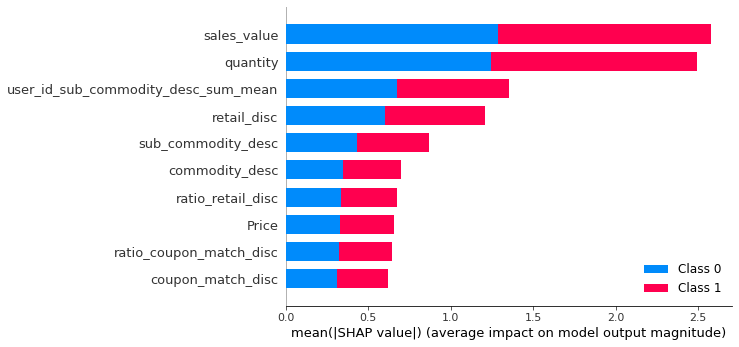

In [226]:
# Важность признаков

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X_test,y_test)
shap.summary_plot(shap_values, X_test,max_display=10 )